<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [10]:
from tqdm import tqdm

import numpy as np

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio import datasets
from torchaudio import transforms

import matplotlib.pyplot as plt

import IPython.display as ipd
import ssl

from torch.utils.data import Dataset, DataLoader

In [11]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

ssl._create_default_https_context = ssl._create_unverified_context
dataset = datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.1*ds_size)
train_i += train_i%2
val_i = int(0.11*ds_size) - train_i
val_i += val_i%2
test_i = ds_size - train_i - val_i
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

bs = 1
sr = 48000
sampleSize = 2048*2

def pad_collate(batch):
    (xx, _, _, _, _) = zip(*batch)
    xx = [x.squeeze() for x in xx]
#     print(xx[0].shape)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0).unsqueeze(1)
#     print(xx_pad.shape)

    return xx_pad

True


In [12]:
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

(4388, 438, 39047, True)

In [126]:
def get_data(train_ds, val_ds, test_ds, bs):
    return (
         DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate, shuffle=True), 
         DataLoader(val_ds, batch_size=2 * bs, collate_fn=pad_collate), 
         DataLoader(test_ds, batch_size=2 * bs, collate_fn=pad_collate),
    )

def preprocess(x):
    ns = int(((((x.shape[1]/HOP_LENGTH-4)/2-3)/2-1)/2-1)/2)
    ns = int(((((ns*2+1)*2+1)*2+3)*2+4)*HOP_LENGTH)
    x = x.narrow(1, 0, ns)
#     x = torch.stft(input=x, n_fft=N_FFT, 
#                           hop_length=HOP_LENGTH, normalized=True)
#     x = x.narrow(2, 0, x.shape[2]-1)
#     x = x.unsqueeze(1)
#     print(x.shape)
    return x.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
#             if len(b.shape) == 3:
#                 b = b.unsqueeze(0)
            inter = torch.stft(b.squeeze(), n_fft=2048, return_complex=True)
            if len(inter.shape) == 2:
                inter = inter.unsqueeze(0)
#             print(inter.shape)
#             print(b.shape)
            a = int(inter.shape[0] * inter.shape[1] * inter.shape[2] /2)
            d0 = torch.randint(inter.shape[0], (1, a))
            d1 = torch.randint(inter.shape[1], (1, a))
            d2 = torch.randint(inter.shape[2], (1, a))
            ll = torch.cat((d0, d1, d2)).numpy()
            inter[ll] = 0
            x = torch.istft(inter, n_fft=2048)
            x_noisy, y_true = self.func(x), self.func(b.squeeze(1))
#             if x_noisy.shape[3] < y_true.shape[3]:
# #                 print(x_noisy.shape, y_true.shape)
#                 y_true = y_true.narrow(3, 0, x_noisy.shape[3])
            yield (x_noisy, y_true)

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

In [127]:
DEVICE = dev
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4
N_FFT, HOP_LENGTH

(3076, 772)

In [15]:
x = next(iter(train_dl))

In [16]:
x[0].shape

torch.Size([1, 140504])

In [52]:
x[0].shape

torch.Size([2, 1539, 342, 2])

In [49]:
x[0].shape

torch.Size([4, 1539, 279, 2])

In [128]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a Short-tome Fourier transform,
    normalizes and leads to a tensor.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

In [129]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output
    
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output
    
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output
    
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted
    
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output    

In [130]:
class DCUnet10(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample2 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample3 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(0,0))
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample3 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45, output_padding=(0,0))
        self.upsample4 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=90, output_padding=(0,1), out_channels=1, last_layer=True)
        
        
    def forward(self, x, is_istft=True):
        
#         print(x.shape)
        x = torch.stft(input=x, n_fft=N_FFT, 
              hop_length=HOP_LENGTH, normalized=True)
        x = x.narrow(2, 0, x.shape[2]-1)
        x = x.unsqueeze(1)
#         print(x.shape)
        
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0) 
        d2 = self.downsample2(d1)        
        d3 = self.downsample3(d2)        
        d4 = self.downsample4(d3)
        
        # upsampling/decoding 
        u0 = self.upsample0(d4)
        # skip-connection
        c0 = torch.cat((u0, d3), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d2), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d1), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d0), dim=1)
        
        u4 = self.upsample4(c3)
        
        # u4 - the mask
        if x.shape[3] < u4.shape[3]:
            x = F.pad(x, (0,0,0,1))
        if u4.shape[3] < x.shape[3]:
            x = x.narrow(3, 0, u4.shape[3])            
#         print(u4.shape, x.shape)
        output = u4 * x
        if is_istft:
            output = torch.squeeze(output, 1)
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

In [131]:
y = x[0]
# y.narrow()
print(y.shape)
z = F.pad(y, (0,0,0,1))
z.shape

torch.Size([1, 115800])


torch.Size([2, 115800])

In [111]:
z[0,:,1,0]

IndexError: too many indices for tensor of dimension 2

In [132]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    x_ = torch.squeeze(x_, 1)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
#     print(y_true_.shape, x_.shape)
#     print(y_true.shape, x.shape)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    if y_pred.shape[1] < y_true.shape[1]:
        y_true = y_true.narrow(1, 0, x.shape[1])
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for batch_idx, (noisy_x, clean_x) in enumerate(train_loader):
        
        clean_x = torch.stft(input=clean_x, n_fft=N_FFT, 
              hop_length=HOP_LENGTH, normalized=True)
        clean_x = clean_x.narrow(2, 0, clean_x.shape[2]-1)
        clean_x = clean_x.unsqueeze(1)
        
        if batch_idx % 100 == 99:
            print(batch_idx, "/", train_i//bs, train_ep_loss / counter)

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)
        
                
        noisy_x = torch.stft(input=noisy_x, n_fft=N_FFT, 
                      hop_length=HOP_LENGTH, normalized=True)
        noisy_x = noisy_x.narrow(2, 0, noisy_x.shape[2]-1)
        noisy_x = noisy_x.unsqueeze(1)
        
#         print(pred_x.shape, clean_x.shape)
#         if pred_x.shape[3] < clean_x.shape[3]:
# #                 print(x_noisy.shape, y_true.shape)
#             clean_x = clean_x.narrow(3, 0, noisy_x.shape[3])
# #         print(x.shape)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for noisy_x, clean_x in test_loader:
        
        clean_x = torch.stft(input=clean_x, n_fft=N_FFT, 
              hop_length=HOP_LENGTH, normalized=True)
        clean_x = clean_x.narrow(2, 0, clean_x.shape[2]-1)
        clean_x = clean_x.unsqueeze(1)
        
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)
        
        noisy_x = torch.stft(input=noisy_x, n_fft=N_FFT, 
              hop_length=HOP_LENGTH, normalized=True)
        noisy_x = noisy_x.narrow(2, 0, noisy_x.shape[2]-1)
        noisy_x = noisy_x.unsqueeze(1)
        
#         print(pred_x.shape, clean_x.shape)
#         if pred_x.shape[3] < clean_x.shape[3]:
# #                 print(x_noisy.shape, y_true.shape)
#             clean_x = clean_x.narrow(3, 0, noisy_x.shape[3])
# #         print(x.shape)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss

def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        if e == 0:
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)
                
            test_losses.append(test_loss)
            print("Loss before training:{:.6f}".format(test_loss))
          

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
        scheduler.step()
        with torch.no_grad():
            test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

def pesq_score(net, test_loader):
    net.eval()
    test_pesq = 0.
    counter = 0.


    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x = noisy_x.to(DEVICE)
        with torch.no_grad():
            pred_x = net(noisy_x)
        clean_x = torch.squeeze(clean_x, 1)
        clean_x = torch.istft(clean_x, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
        
        
        psq = 0.
        for i in range(len(clean_x)):
            clean_x_16 = torchaudio.transforms.Resample(48000, 16000)(clean_x[i, 0,:].view(1,-1))
            pred_x_16 = torchaudio.transforms.Resample(48000, 16000)(pred_x[i, 0,:].view(1,-1))

            clean_x_16 = clean_x_16.cpu().cpu().numpy()
            pred_x_16 = pred_x_16.detach().cpu().numpy()
            
            
            
            psq += pesq(clean_x_16.flatten(), pred_x_16.flatten(), 16000)
            
        psq /= len(clean_x)
        test_pesq += psq
        counter += 1

    test_pesq /= counter 
    return test_pesq

In [133]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [134]:
dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)

In [135]:
loss_fn = wsdr_fn
optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
# optimizer = torch.optim.Adadelta(dcunet10.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [158]:
train_losses, test_losses = train(dcunet10, train_dl, val_dl, loss_fn, optimizer, scheduler, 100)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Loss before training:-0.768346
99 / 4388 -0.7667864434646837
199 / 4388 -0.7641207731548866
299 / 4388 -0.7652708066745745
399 / 4388 -0.7648335205283678
499 / 4388 -0.7651564351064648
599 / 4388 -0.7650332986213926
699 / 4388 -0.7654932274327257
799 / 4388 -0.7661358391089792
899 / 4388 -0.7658785166544166
999 / 4388 -0.7656176827691339
1099 / 4388 -0.7657790078804426
1199 / 4388 -0.7655436078442247
1299 / 4388 -0.7654181861069865
1399 / 4388 -0.7656592046302757
1499 / 4388 -0.7657015684686398
1599 / 4388 -0.7656848159262805
1699 / 4388 -0.7657995582539029
1799 / 4388 -0.7658001508826743
1899 / 4388 -0.7658688733928012
1999 / 4388 -0.7658373251028094
2099 / 4388 -0.7657966654660759
2199 / 4388 -0.7657311672294829
2299 / 4388 -0.7656446318618108
2399 / 4388 -0.7656620705112809
2499 / 4388 -0.7658318562620208
2599 / 4388 -0.7658544428855835
2699 / 4388 -0.7658758400854865
2799 / 4388 -0.7657981048357747
2899 / 4388 -0.7660081712448749
2999 / 4388 -0.7658911526859026
3099 / 4388 -0.76595

  1%|▊                                                                             | 1/100 [11:51<19:33:50, 711.42s/it]

Epoch: 1/100... Loss: -0.766011... Test Loss: -0.767761
99 / 4388 -0.7700946933091289
199 / 4388 -0.7671332880480206
299 / 4388 -0.766074886290126
399 / 4388 -0.7658540542263136
499 / 4388 -0.7667503126398595
599 / 4388 -0.7670575251961391
699 / 4388 -0.7671291470016021
799 / 4388 -0.7670543607841893
899 / 4388 -0.7670000005219219
999 / 4388 -0.7667126050582519
1099 / 4388 -0.7664768288523853
1199 / 4388 -0.766650789822013
1299 / 4388 -0.7664296268223798
1399 / 4388 -0.7662500795762482
1499 / 4388 -0.7662828595658951
1599 / 4388 -0.7662090324774021
1699 / 4388 -0.7661670352024776
1799 / 4388 -0.7663987833238297
1899 / 4388 -0.7664672211950362
1999 / 4388 -0.7666064894694338
2099 / 4388 -0.7666071412846155
2199 / 4388 -0.766543288185359
2299 / 4388 -0.7666335364640822
2399 / 4388 -0.7665612761206108
2499 / 4388 -0.7665156129600048
2599 / 4388 -0.7666546966122315
2699 / 4388 -0.7666599804182854
2799 / 4388 -0.7667151686548122
2899 / 4388 -0.766691117193749
2999 / 4388 -0.7666517550168573

  2%|█▌                                                                            | 2/100 [23:19<18:59:11, 697.46s/it]

Epoch: 2/100... Loss: -0.766551... Test Loss: -0.765045
99 / 4388 -0.7622346143529872
199 / 4388 -0.7662521756474098
299 / 4388 -0.7642572611869378
399 / 4388 -0.765963531825178
499 / 4388 -0.7663061051426049


  2%|█▌                                                                            | 2/100 [24:44<20:12:31, 742.36s/it]


KeyboardInterrupt: 

In [17]:
torch.save(dcunet10.state_dict(), "dcu.pth")

In [29]:
dcunet10

DCUnet10(
  (downsample0): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(1, 45, kernel_size=(7, 5), stride=(2, 2))
      (im_conv): Conv2d(1, 45, kernel_size=(7, 5), stride=(2, 2))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (downsample1): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(45, 90, kernel_size=(7, 5), stride=(2, 2))
      (im_conv): Conv2d(45, 90, kernel_size=(7, 5), stride=(2, 2))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (downsample2): Encoder(
    (cconv): CConv2d(
      (real_conv

In [27]:
from torchsummary import summary
summary(dcunet10, (1, 1539, 278, 2))

torch.Size([2, 1, 1539, 278, 2])
torch.Size([2, 1, 1539, 278, 2]) torch.Size([2, 1, 1539, 278, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 45, 767, 137]           1,620
            Conv2d-2         [-1, 45, 767, 137]           1,620
            Conv2d-3         [-1, 45, 767, 137]           1,620
            Conv2d-4         [-1, 45, 767, 137]           1,620
           CConv2d-5      [-1, 45, 767, 137, 2]               0
       BatchNorm2d-6         [-1, 45, 767, 137]              90
       BatchNorm2d-7         [-1, 45, 767, 137]              90
      CBatchNorm2d-8      [-1, 45, 767, 137, 2]               0
         LeakyReLU-9      [-1, 45, 767, 137, 2]               0
          Encoder-10      [-1, 45, 767, 137, 2]               0
           Conv2d-11          [-1, 90, 381, 67]         141,840
           Conv2d-12          [-1, 90, 381, 67]         141,840
    

In [159]:
xi = iter(val_dl)

In [160]:
x = next(xi)
x_noisy_ = x[0][0]
x_noisy = x_noisy_#torch.istft(x_noisy_, n_fft=N_FFT)
x_true_ = x[1][0]
x_true = x_true_#torch.istft(x_true_, n_fft=N_FFT)

In [161]:
x_noisy.shape

torch.Size([189912])

In [162]:
with torch.no_grad():
    x_pred = dcunet10(x_noisy_.unsqueeze(0))
x_pred = x_pred / (x_pred.max() - x_pred.min()) * (x_true.max() - x_true.min())
# x_pred = x_pred - x_pred.min() + x_true.min()
# x_pred = x_pred - x_pred[0, -1]
# x_pred = torch.istft(x_pred_, n_fft=N_FFT)

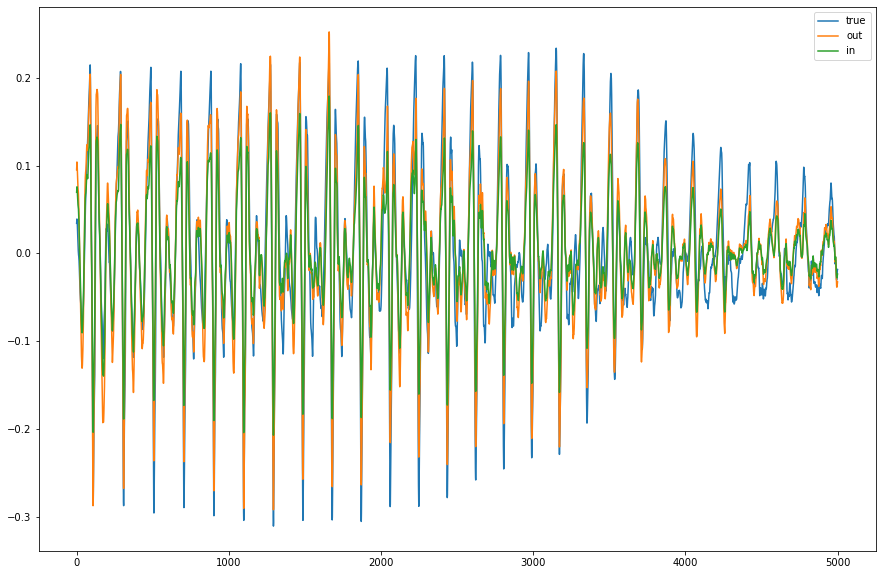

In [163]:
sl = slice(50000, 55000)
plt.figure(figsize=(15,10))
plt.plot(x_true.squeeze().cpu()[sl])
plt.plot(x_pred.squeeze().cpu()[sl])

plt.plot(x_noisy.squeeze().cpu()[sl])
plt.legend(["true", "out", "in"])

In [164]:
display(ipd.Audio(x_noisy.squeeze().cpu(), rate=sr));

In [165]:
display(ipd.Audio(x_true.squeeze().cpu(), rate=sr));

In [166]:
display(ipd.Audio(x_pred.squeeze().cpu(), rate=sr));